<a href="https://colab.research.google.com/github/dguevaraapaza/H1N1-Seasonal-Flu-Vaccine/blob/main/H1N1_and_seasonal_flu_vaccines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vaccination Prediction


> **Goal:** Predict how likely individuals are to receive their H1N1 and seasonal flu vaccines. In specific, the target is to predict two probabilities: one for h1n1_vaccine and one for seasonal_vaccine.

**This is a multi-label classification problem.**

In [1]:
# !pip install -q pandas
# !pip install -q numpy
# !pip install -q matplotlib
# !pip install -q scikit-learn
# !pip install -q seaborn
# !pip install -q missingno
# !pip install -q fancyimpute

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA

# Libraries for model training
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split , GridSearchCV , cross_val_score

# Libraries for algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Impute binary data
from fancyimpute import IterativeImputer

# Libraries for testing
from sklearn.metrics import accuracy_score , classification_report

# Removing warnings
import warnings
warnings.filterwarnings('ignore')

#Check missing values
import missingno as msno

# Storing plots
%matplotlib inline

## **1. Data Wrangling**

In [4]:
# donwload data
# !wget -q -O data/H1N1_Flu_Vaccines.csv \
# 	https://raw.githubusercontent.com/dguevaraapaza/H1N1-Seasonal-Flu-Vaccine/refs/heads/main/data/H1N1_Flu_Vaccines.csv
# Load data
vac = pd.read_csv('data/H1N1_Flu_Vaccines.csv', index_col='respondent_id', delimiter=',')
display(vac.head())
print(f'Dataset strcuture: {vac.shape}')

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


Dataset strcuture: (26707, 37)


In [5]:
# Find and print duplicated rows based on the index of the 'vac' DataFrame.
duplicated_rows = vac[vac.index.duplicated(keep=False)]
print(f'There are {duplicated_rows.shape[0]} duplicated records.')

There are 0 duplicated records.


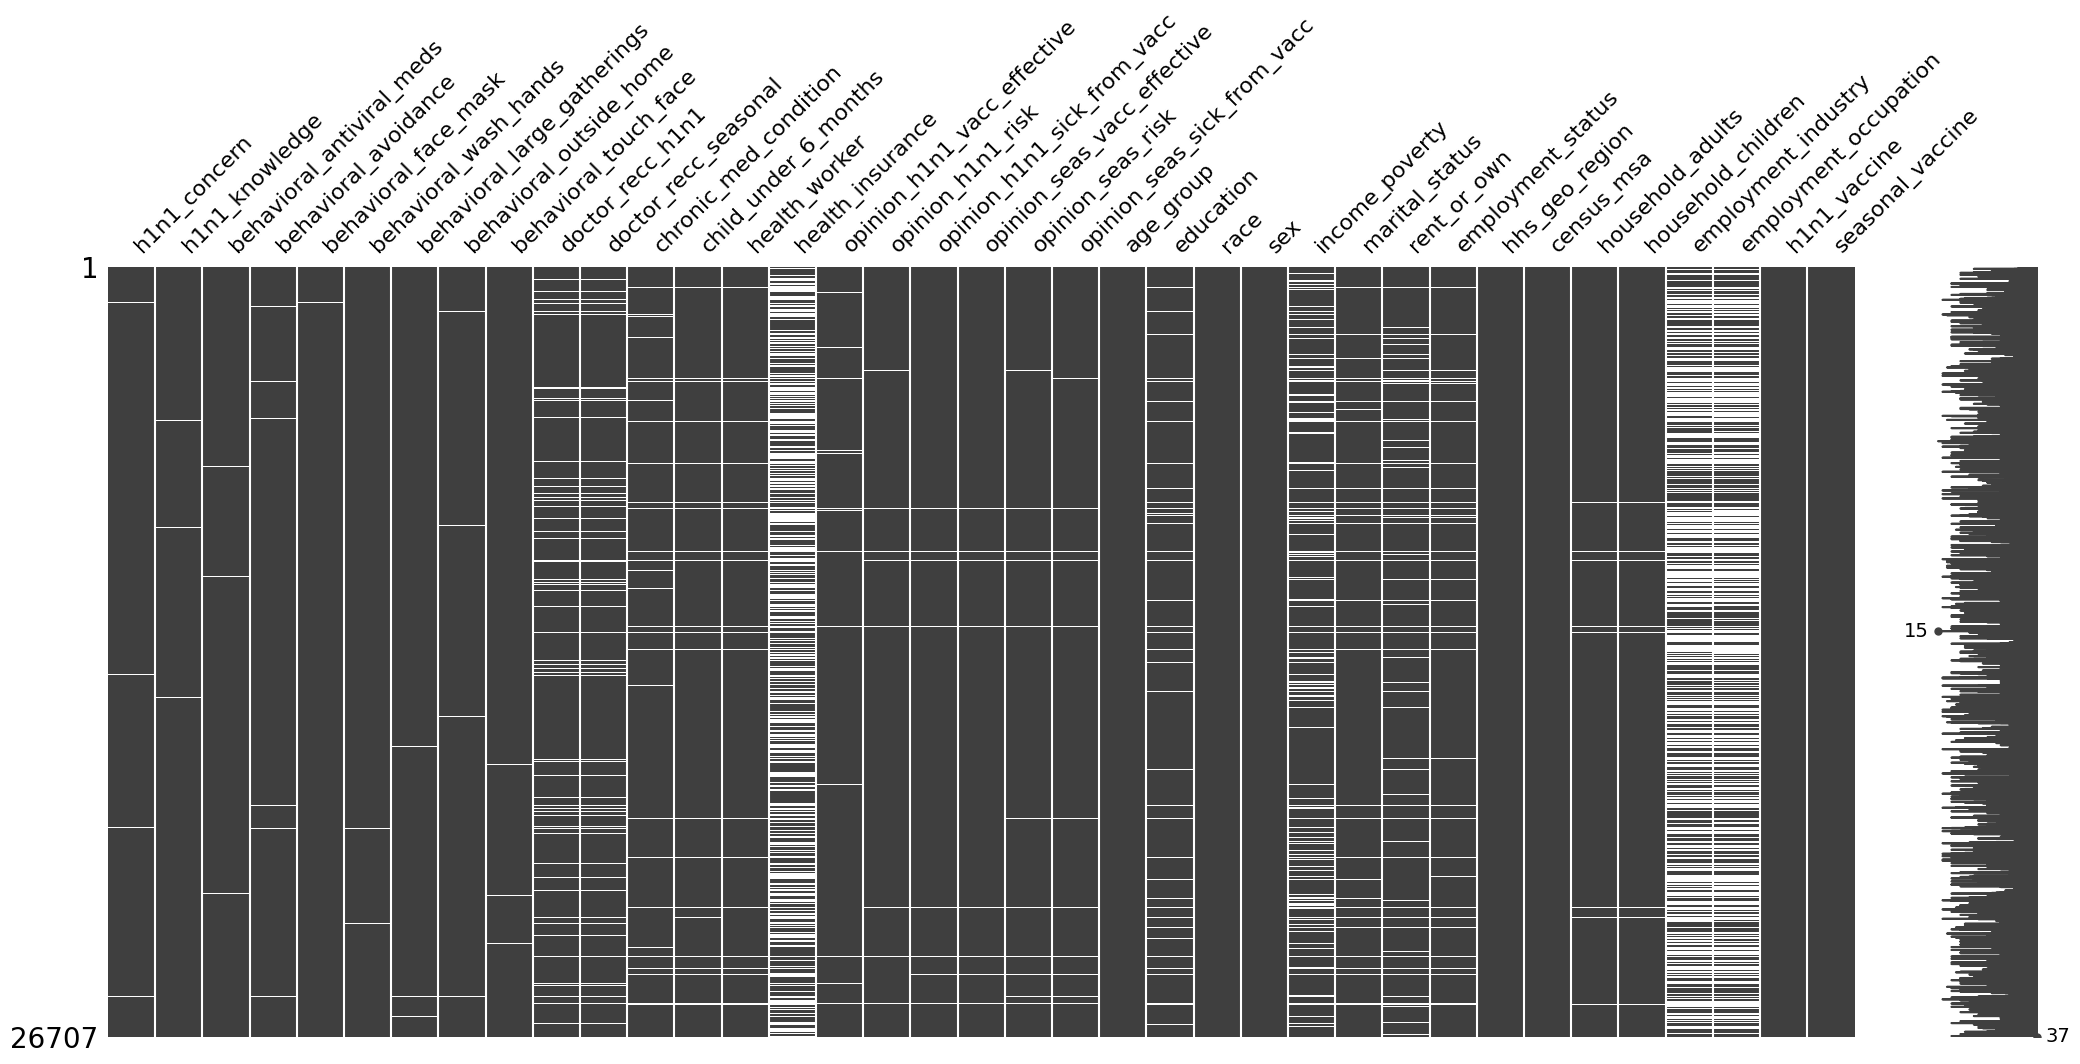

In [6]:
# review empty values
msno.matrix(vac)
plt.show()

In [7]:
# Remove records that have multiple empty values

# Calculate the number of missing values per row
missing_counts = vac.isnull().sum(axis=1)

# Find rows with more than a certain threshold of missing values
threshold = 5  #max missing values
rows_with_multiple_missing = vac[missing_counts > threshold]

# Alternatively, to just get the indices of these rows
indices_with_multiple_missing = rows_with_multiple_missing.index.tolist()

# Dropping the values in indices_with_multiple_missing
vac = vac.drop(indices_with_multiple_missing)
print(f"Removed: {len(indices_with_multiple_missing)} records")

Removed: 1609 records


In [8]:
# Remove columns based on the missing values
na_counts = pd.DataFrame()

for col in vac.columns:
    true_count = vac[col].isna().sum()
    false_count = len(vac) - true_count  # Calculate false counts
    na_counts = pd.concat([na_counts, pd.DataFrame({'Column': [col], 'Empty': [true_count], 'Non-Empty': [false_count]})], ignore_index=True)

na_counts = na_counts.sort_values(by='Empty', ascending=False)
na_counts.head(10)

,Column,Empty,Non-Empty
34,employment_occupation,11868,13230
33,employment_industry,11731,13367
14,health_insurance,10739,14359
25,income_poverty,2892,22206
9,doctor_recc_h1n1,1709,23389
10,doctor_recc_seasonal,1709,23389
27,rent_or_own,651,24447
11,chronic_med_condition,198,24900
3,behavioral_avoidance,167,24931
22,education,126,24972


In [9]:
# group variables for imputation
h1n1_concern = ['h1n1_concern', 'h1n1_knowledge'] # categorical
behaviour = ['behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 
             'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 
             'behavioral_touch_face'] #binary
recomendation = ['doctor_recc_h1n1', 'doctor_recc_seasonal'] #binary
health_condition = ['chronic_med_condition', 'child_under_6_months', 'health_worker'] #, 'health_insurance'] #Binary
opinion = ['opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
           'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
           'opinion_seas_risk', 'opinion_seas_sick_from_vacc'] # categorical
demographics = ['age_group','education', 'race', 'sex', 'income_poverty',
                'marital_status', 'rent_or_own', 'employment_status'] #, 'employment_industry', 'employment_occupation'] # categorical
household_info = ['hhs_geo_region', 'census_msa', 'household_adults',
                  'household_children'] # categorical
predictors = ['h1n1_vaccine', 'seasonal_vaccine']

# variables to remove
remove = ['health_insurance', 'employment_industry', 'employment_occupation'] # more than 10 000 empty values
vac = vac.drop(columns=remove) # drop the variables in remove

# variable to impute
cat_variable = h1n1_concern + opinion + demographics + household_info
bin_variable = behaviour + recomendation + health_condition

> Here I removed a very important feature `health insurance` consideriing that almost half of the dataset is incomplete in this matter. In case the model need to be improved this could be a greater point to backtrack and only work with the chunk of data available.

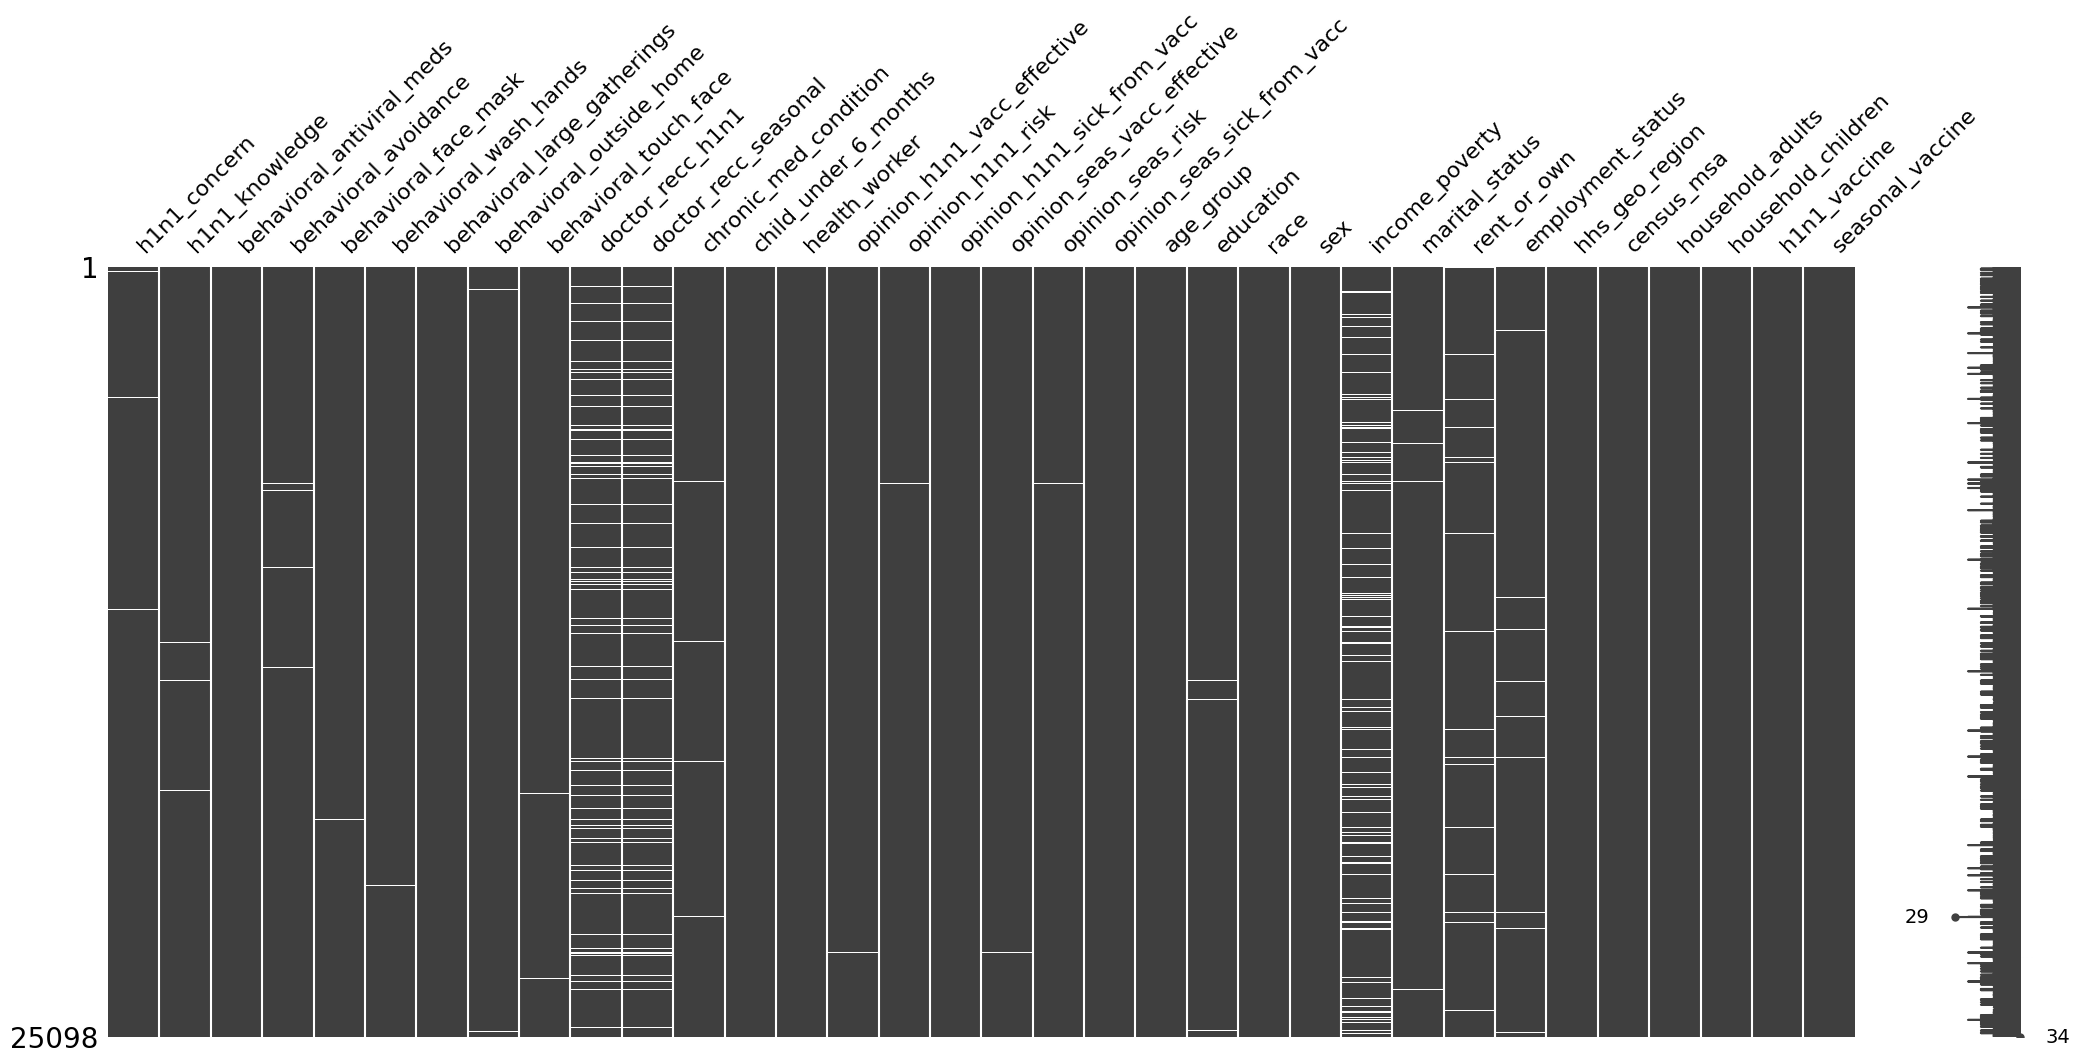

In [10]:
# missing values matrix
msno.matrix(vac)
plt.show()

In [11]:
# Imputation
def review_per_col(i):
	print(f'***********************')
	print(i)
	print(f'***********************')
	print(vac[i].value_counts())
	print(f'-----------------------')
	print(vac[i].isna().value_counts())
	print(f'-----------------------\n\n')

In [12]:
# Impute categorical variables
# for col in vac[cat_variable]:
# 	review_per_col(col)

In [13]:
# imputation by probability
for col in vac[cat_variable]:
    value_counts = vac[col].value_counts(normalize=True)  # Normalize to get probabilities
    categories = value_counts.index  # Unique non-missing values
    probabilities = value_counts.values  # Corresponding probabilities

    # Fill missing values probabilistically
    vac[col] = vac[col].fillna(
        pd.Series(
            np.random.choice(categories, size=vac[col].isna().sum(), p=probabilities),
            index=vac[col][vac[col].isna()].index  # Ensure alignment with missing indices
        )
    )

In [14]:
# Impute binary variables
# for col in vac[bin_variable]:
# 	review_per_col(col)

In [15]:
# Impute binary variables using MICE
imputer = IterativeImputer(max_iter=10, random_state=0) # Apply MICE imputation
vac[bin_variable] = imputer.fit_transform(vac[bin_variable])

for col in vac[bin_variable]:
	# Convert imputed values to binary
	vac[col] = (vac[col] > 0.5).astype(int)


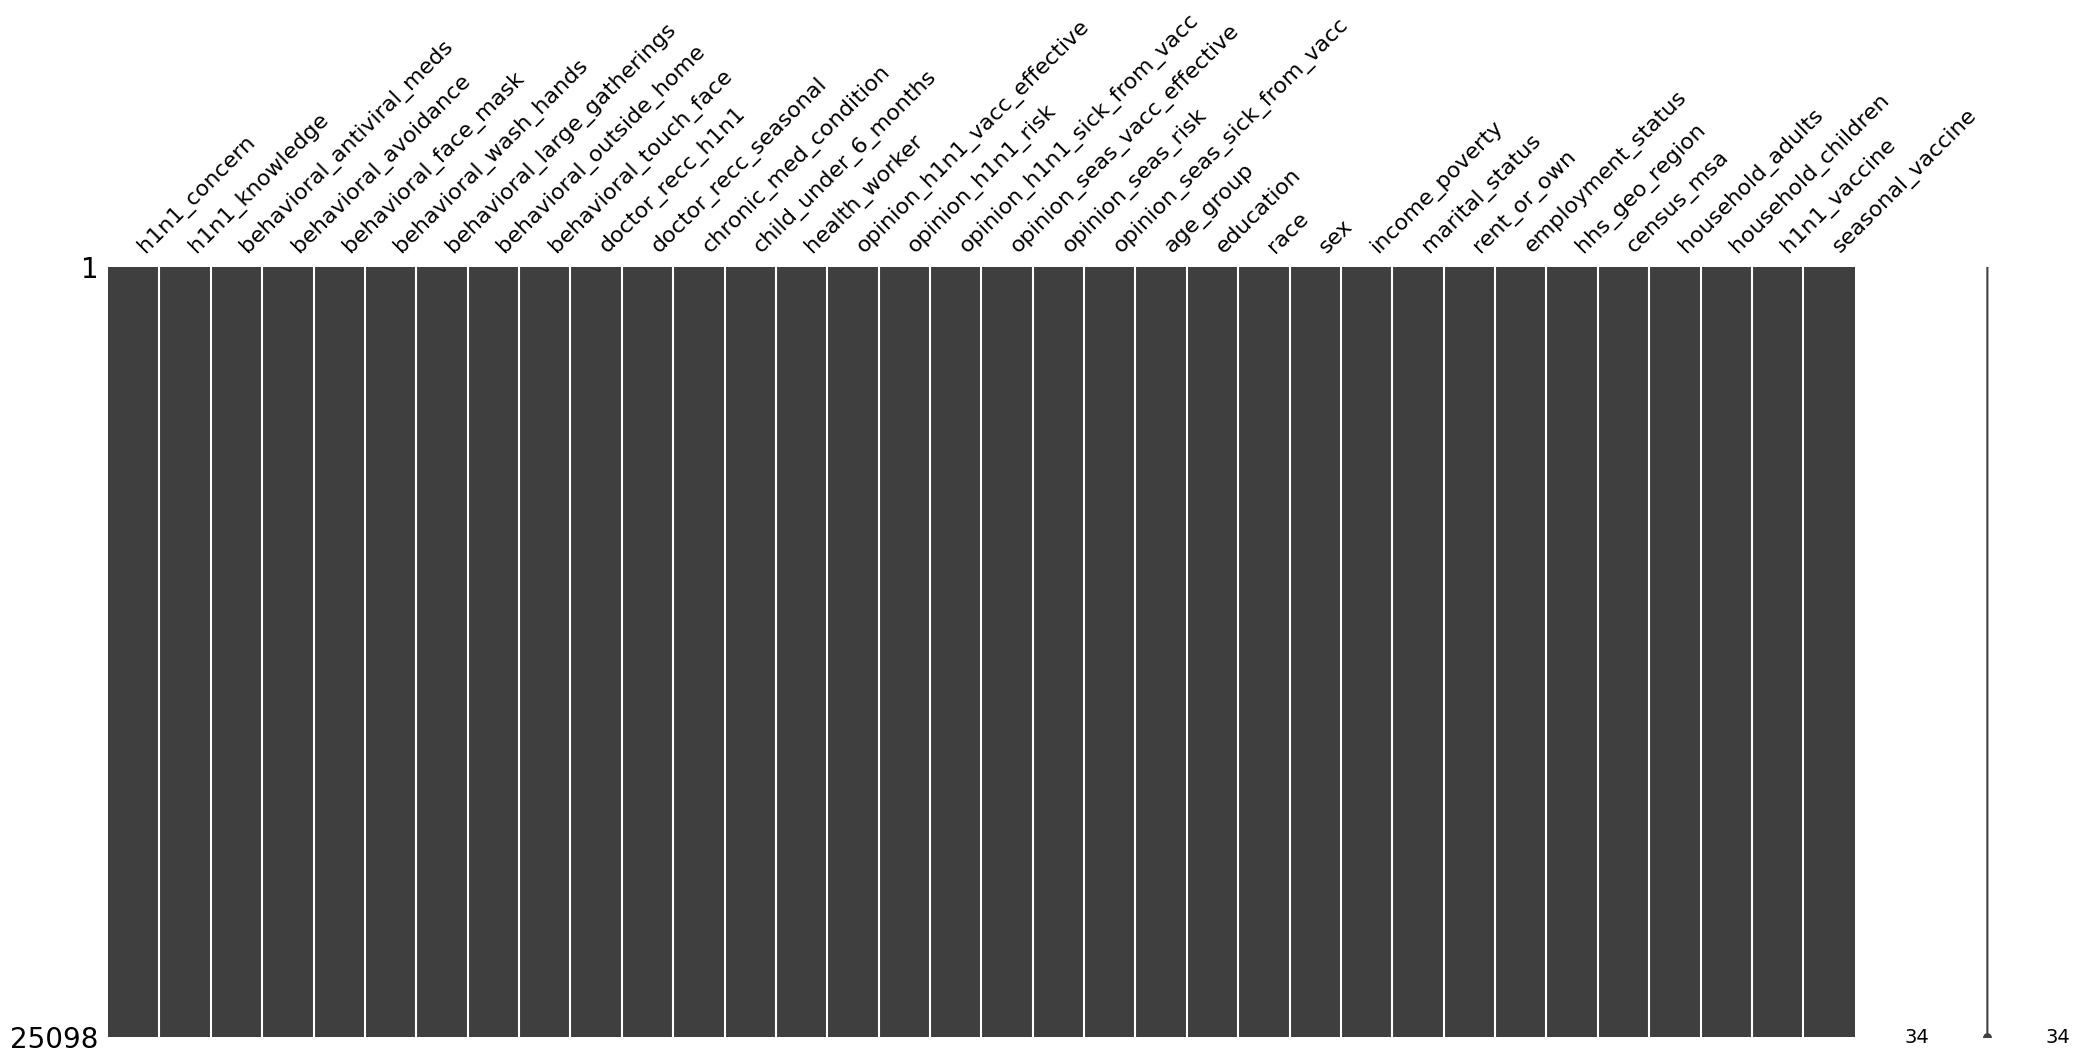

In [16]:
# evaluate again
msno.matrix(vac)
plt.show()

## **2. Exploratory analysis**

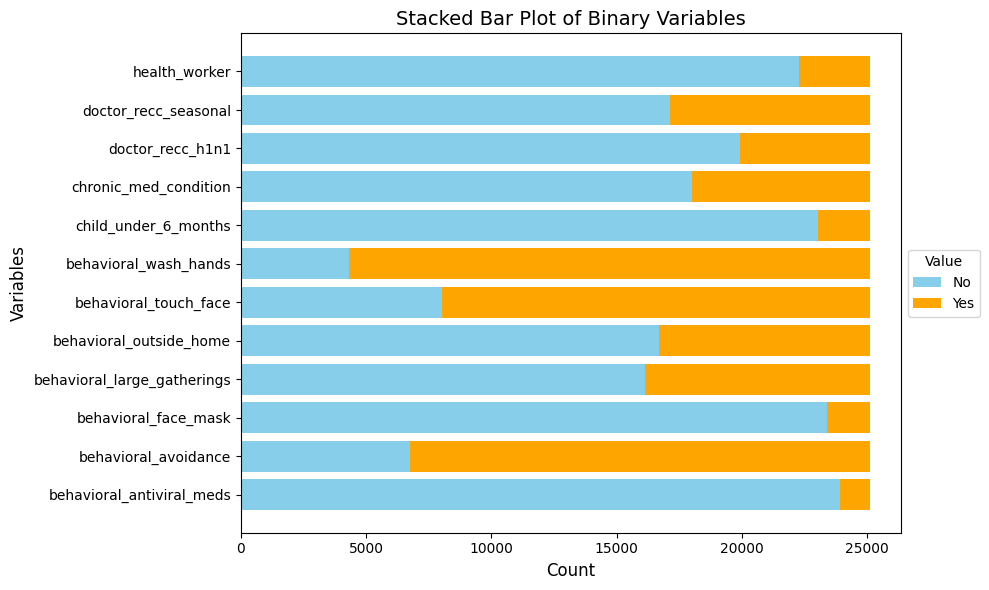

In [17]:
## Visulizating all binary variables

# Stackbar
melted_data = vac[bin_variable].melt(var_name='Variable', value_name='Value')

# Count occurrences of 0s and 1s for each variable
counts = melted_data.groupby(['Variable', 'Value']).size().reset_index(name='Count')
counts = counts.pivot(index='Variable', columns='Value', values='Count')

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(counts.index, counts[0], color='skyblue', label='No')
plt.barh(counts.index, counts[1], left=counts[0], color='orange', label='Yes')

# Customizing the plot
plt.title('Stacked Bar Plot of Binary Variables', fontsize=14)
plt.ylabel('Variables', fontsize=12)
plt.xlabel('Count', fontsize=12)
plt.legend(title='Value', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

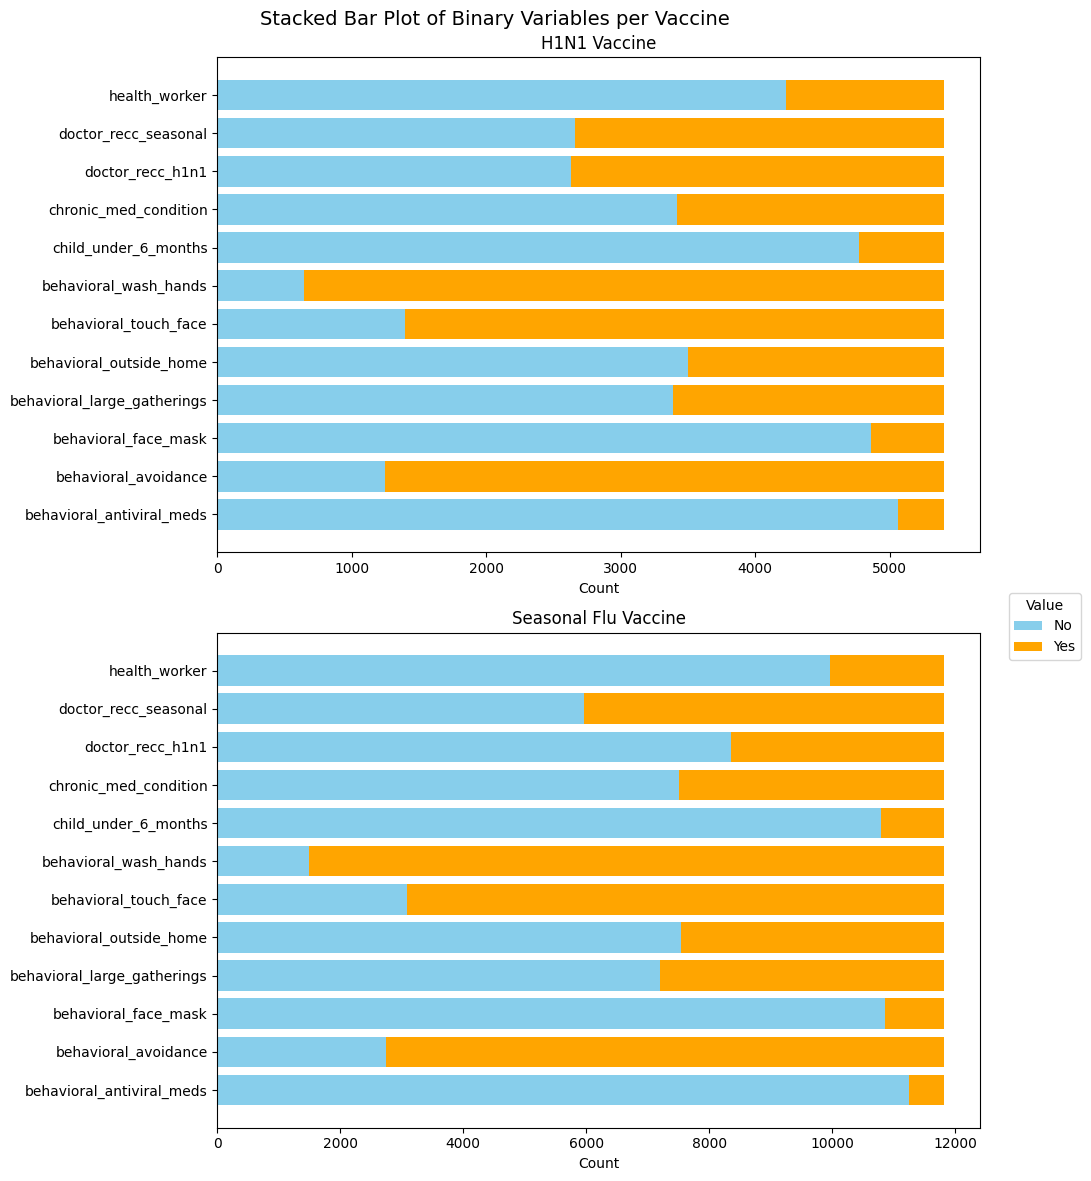

In [18]:
# Comparison between h1n1 and seasonal flu

# H1N1 vaccine data
vac_h1n1 = vac.loc[vac.h1n1_vaccine == 1]
melted_data1 = vac_h1n1[bin_variable].melt(var_name='Variable', value_name='Value')
counts1 = melted_data1.groupby(['Variable', 'Value']).size().reset_index(name='Count')
counts1 = counts1.pivot(index='Variable', columns='Value', values='Count')

# Seasonal flu vaccine data
vac_flu = vac.loc[vac.seasonal_vaccine == 1]
melted_data2 = vac_flu[bin_variable].melt(var_name='Variable', value_name='Value')
counts2 = melted_data2.groupby(['Variable', 'Value']).size().reset_index(name='Count')
counts2 = counts2.pivot(index='Variable', columns='Value', values='Count')

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))  # Side-by-side plots
fig.suptitle('Stacked Bar Plot of Binary Variables per Vaccine', fontsize=14)

# Colors for the bars
colors = ['skyblue', 'orange']

# Plot for H1N1 vaccine
ax1.barh(counts1.index, counts1[0], color=colors[0])
ax1.barh(counts1.index, counts1[1], left=counts1[0], color=colors[1])
ax1.set_title('H1N1 Vaccine')
ax1.set_xlabel('Count')

# Plot for Seasonal flu vaccine
ax2.barh(counts2.index, counts2[0], color=colors[0])
ax2.barh(counts2.index, counts2[1], left=counts2[0], color=colors[1])
ax2.set_title('Seasonal Flu Vaccine')
ax2.set_xlabel('Count')

# Add a single legend for the figure
fig.legend(
    labels=['No', 'Yes'],
    loc='upper center', 
    bbox_to_anchor=(1.05, 0.5),
    title='Value'
)

# Adjust layout
plt.tight_layout()
plt.show()

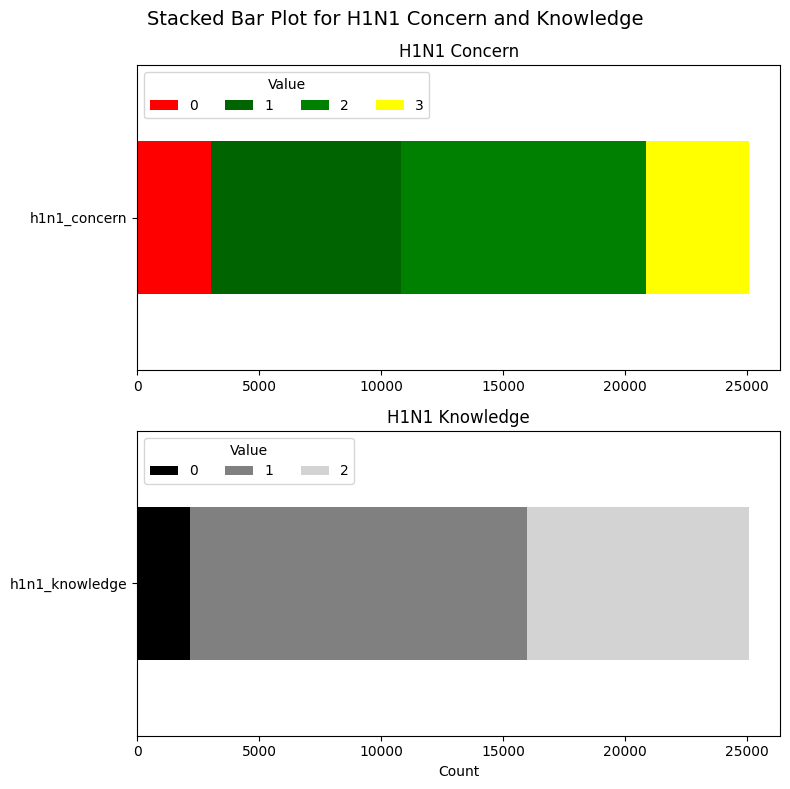

In [19]:
# h1n1_concern	h1n1_knowledge

# Count values for each column
concern_counts = vac['h1n1_concern'].value_counts().sort_index()
knowledge_counts = vac['h1n1_knowledge'].value_counts().sort_index()

# Combine the counts into a single DataFrame for stacking
stacked_data = pd.DataFrame({
    'h1n1_concern': concern_counts,
    'h1n1_knowledge': knowledge_counts
}).T.reset_index(names='Variable')

melted_df = stacked_data.melt(id_vars=['Variable'], var_name='Value', value_name='Count')
melted_df.Value = melted_df.Value.astype(int)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))  # Vertical plots
fig.suptitle('Stacked Bar Plot for H1N1 Concern and Knowledge', fontsize=14)

# Plot for H1N1 Concern
concern_data = melted_df[melted_df['Variable'] == 'h1n1_concern']
concern_pivot = concern_data.pivot_table(index='Variable', columns='Value', values='Count', aggfunc='sum')
concern_pivot.plot(kind='barh', stacked=True, ax=ax1, color=['red', 'darkgreen', 'green', 'yellow'])

ax1.set_title('H1N1 Concern')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.legend(title='Value', loc='upper left', ncols = 4)

# Plot for H1N1 Knowledge
knowledge_data = melted_df[melted_df['Variable'] == 'h1n1_knowledge']
knowledge_pivot = knowledge_data.pivot_table(index='Variable', columns='Value', values='Count', aggfunc='sum')
knowledge_pivot.plot(kind='barh', stacked=True, ax=ax2, color=['black', 'grey', 'lightgrey'])

ax2.set_title('H1N1 Knowledge')
ax2.set_xlabel('Count')
ax2.set_ylabel('')
ax2.legend(title='Value', labels=['0', '1', '2'], loc='upper left', ncols = 4)

# Adjust layout
plt.tight_layout()
plt.show()

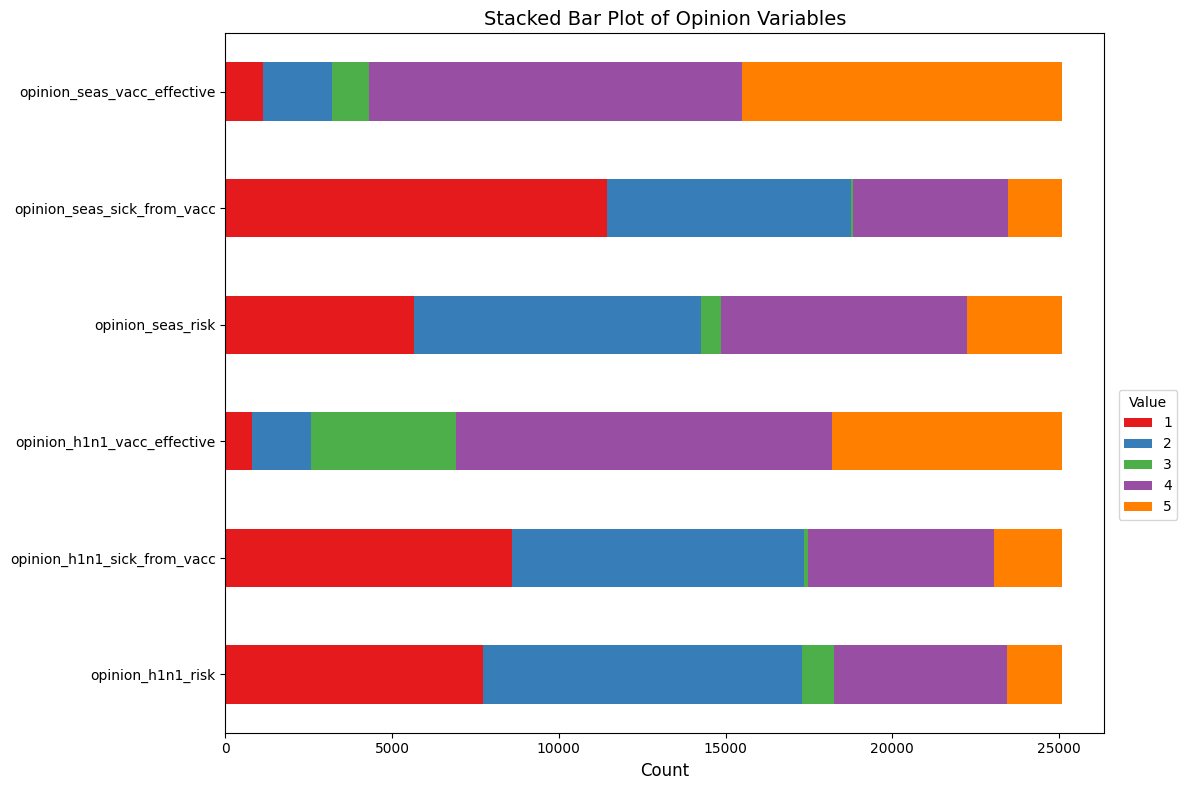

In [20]:
# Opinion

## Visulizating opinion variables

# Stackbar
melted_data = vac[opinion].melt(var_name='Variable', value_name='Value')

# Count occurrences of 0s and 1s for each variable
counts = melted_data.groupby(['Variable', 'Value']).size().reset_index(name='Count')
counts.Value = counts.Value.astype(int)
# Pivot the DataFrame to create a pivot table
pivot_df = counts.pivot_table(index='Variable', columns='Value', values='Count', aggfunc='sum', fill_value=0)

# Create a figure and set its size explicitly
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the size here

# Plotting the stacked bar plot
pivot_df.plot(kind='barh', stacked=True, color=plt.cm.Set1.colors, ax=ax)  # Specify the ax here

# Customizing the plot
ax.set_title('Stacked Bar Plot of Opinion Variables', fontsize=14)
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('')
ax.legend(title='Value', loc='upper center', bbox_to_anchor=(1.05, 0.5))

# Ensure the layout is tight
plt.tight_layout()

# Show the plot
plt.show()

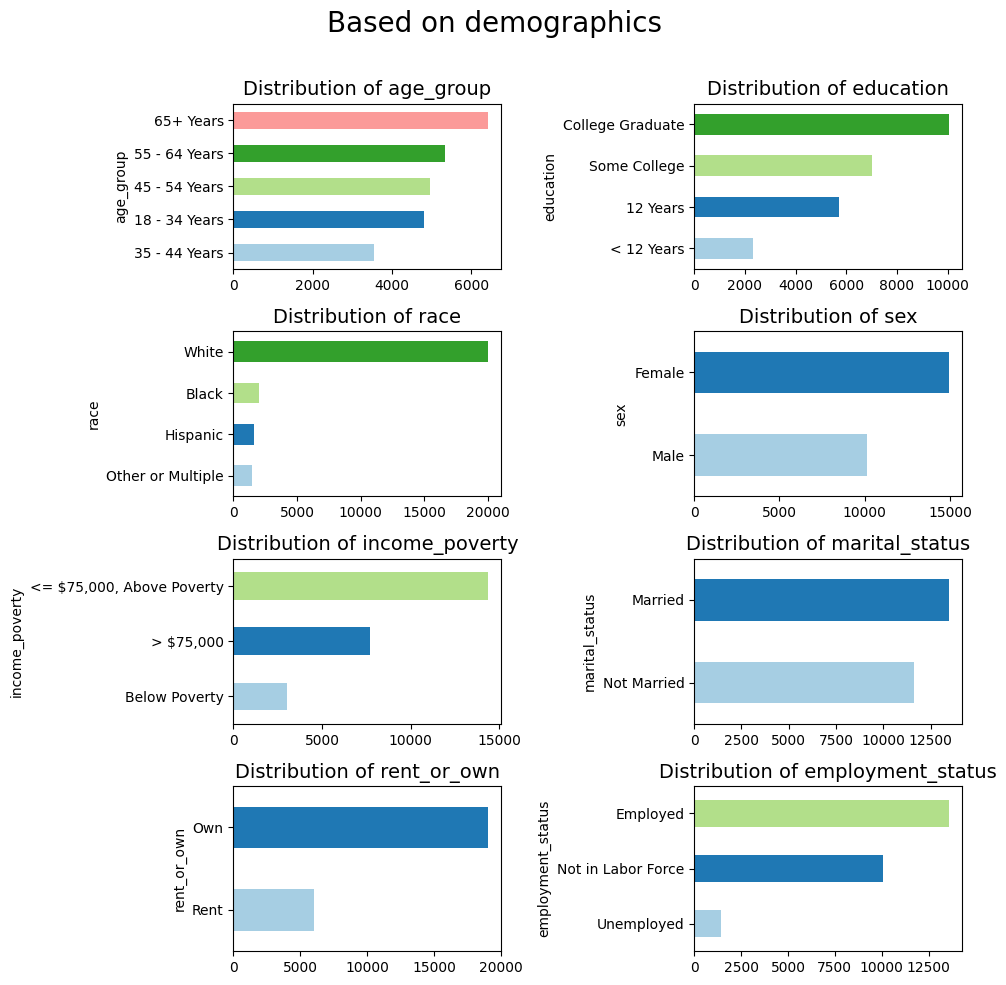

In [21]:
# Demographics

# Plot
fig, axes = plt.subplots(4, 2, figsize=(10, 10))  # 4 rows, 2 columns
axes = axes.flatten()  # Flatten the axes array for easier access

# Loop through each column to plot
for i, column in enumerate(demographics):
    ax = axes[i]  # Get the corresponding subplot axis
    value_counts = vac[column].value_counts()  # Get the counts of each category
    value_counts.sort_values(ascending=True).plot(kind='barh', ax=ax, color=plt.cm.Paired.colors)  # Horizontal bar chart

    # Set the title and labels for the plot
    ax.set_title(f'Distribution of {column}', fontsize=14)
    # ax.set_xlabel('Count', fontsize=12)
    # ax.set_ylabel('Category', fontsize=12)

# Adjust the layout to prevent overlap
plt.suptitle('Based on demographics\n', fontsize=20)
plt.tight_layout()
plt.show()

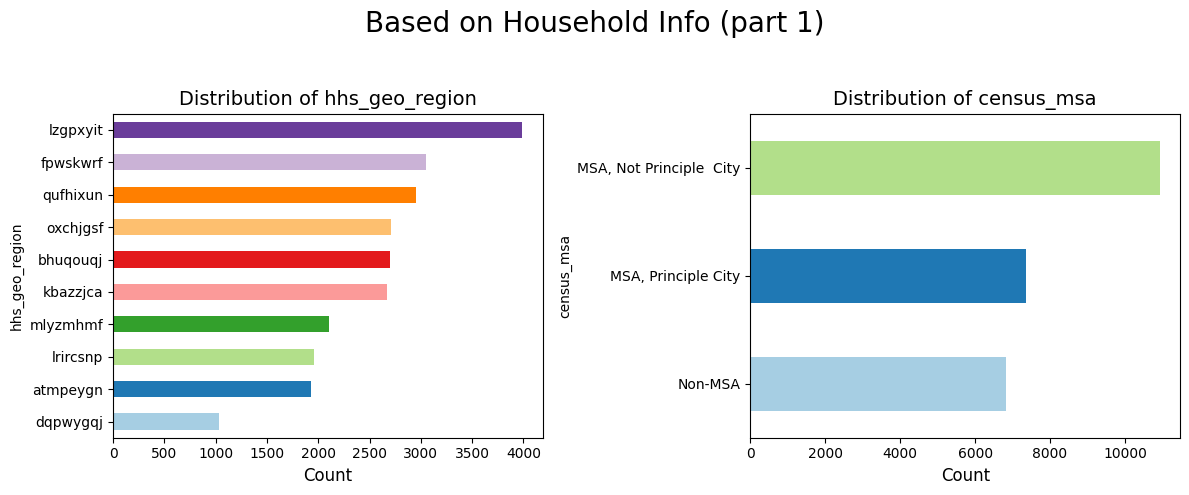

In [22]:
# Household_info (par 1)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 4 rows, 2 columns
axes = axes.flatten()  # Flatten the axes array for easier access

# Loop through each column to plot
for i, column in enumerate(['hhs_geo_region', 'census_msa']):
    ax = axes[i]  # Get the corresponding subplot axis
    value_counts = vac[column].value_counts()  # Get the counts of each category
    value_counts.sort_values(ascending=True).plot(kind='barh', ax=ax, color=plt.cm.Paired.colors)  # Horizontal bar chart

    # Set the title and labels for the plot
    ax.set_title(f'Distribution of {column}', fontsize=14)
    ax.set_xlabel('Count', fontsize=12)
    # ax.set_ylabel('Category', fontsize=12)

# Adjust the layout to prevent overlap
plt.suptitle('Based on Household Info (part 1)\n', fontsize=20)
plt.tight_layout()
plt.show()

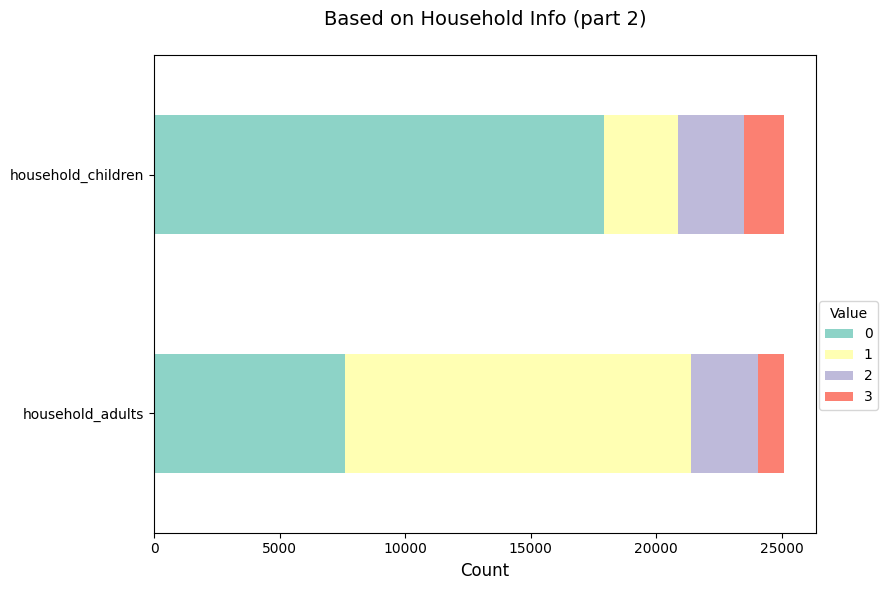

In [23]:
# Household part 2

## Visulizating opinion variables

# Stackbar
melted_data = vac[['household_adults', 'household_children']].melt(var_name='Variable', value_name='Value')

# Count occurrences of 0s and 1s for each variable
counts = melted_data.groupby(['Variable', 'Value']).size().reset_index(name='Count')
counts.Value = counts.Value.astype(int)
# Pivot the DataFrame to create a pivot table
pivot_df = counts.pivot_table(index='Variable', columns='Value', values='Count', aggfunc='sum', fill_value=0)

# Create a figure and set its size explicitly
fig, ax = plt.subplots(figsize=(9, 6))  # Adjust the size here

# Plotting the stacked bar plot
pivot_df.plot(kind='barh', stacked=True, color=plt.cm.Set3.colors, ax=ax)  # Specify the ax here

# Customizing the plot
ax.set_title('Based on Household Info (part 2)\n', fontsize=14)
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('')
ax.legend(title='Value', loc='upper center', bbox_to_anchor=(1.05, 0.5))

# Ensure the layout is tight
plt.tight_layout()

# Show the plot
plt.show()

> **Visualising labels**

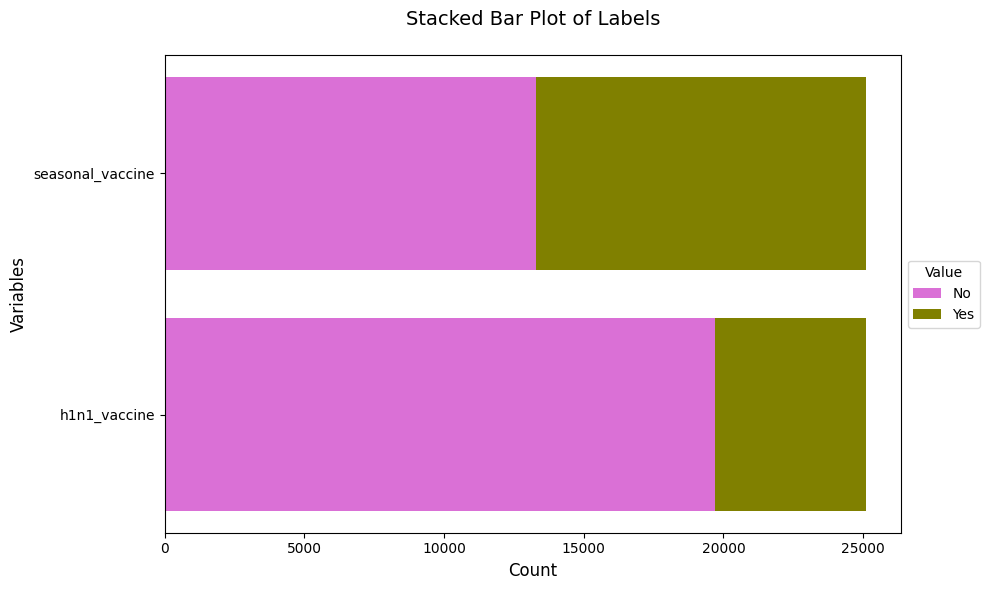

In [24]:
# Comparison between labels: h1n1 and seasonal flu

# label selection
melted_data = vac[predictors].melt(var_name='Variable', value_name='Value')
counts = melted_data.groupby(['Variable', 'Value']).size().reset_index(name='Count')
counts = counts.pivot(index='Variable', columns='Value', values='Count')

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(counts.index, counts[0], color='orchid', label='No')
plt.barh(counts.index, counts[1], left=counts[0], color='olive', label='Yes')

# Customizing the plot
plt.title('Stacked Bar Plot of Labels\n', fontsize=14)
plt.ylabel('Variables', fontsize=12)
plt.xlabel('Count', fontsize=12)
plt.legend(title='Value', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

In [25]:
# export dataset
vac.to_csv('data/fixed_H1N1_Flu_Vaccines.csv', index=True)